# Implementacija predikcije ocene parfema uz korišćenje _XGBoost_ i _Random Forest_

Pre svega treba importovati sve potrebne pakete koji će nam služiti za analizu.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re
from ast import literal_eval
import matplotlib.pyplot as plt

2025-09-14 17:03:04.986328: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-14 17:03:04.990257: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 17:03:05.289190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 17:03:06.436368: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Funckija `parse_season_ratings()` služi za za parsiranje polja godišnjih doba iz skupa podataka, dok funckija `consolidate_notes()` objedinjuje/konsoliduje _base_, _middle_ i _top_ note u jednu kolekciju.

In [ ]:
def parse_season_ratings(rating_str):
    pattern = r'([A-Za-z]+):\s*([0-9.]+)%'
    return {season: float(percent) for season, percent in re.findall(pattern, rating_str)}

def consolidate_notes(notes):
    all_notes = []
    for note_type in ['Top Notes', 'Middle Notes', 'Base Notes']:
        if note_type in notes:
            all_notes.extend(notes[note_type])
    return all_notes

Učitavanje skupa podataka:

In [3]:
file_path = "../datasets/mainDataset.csv"  
data = pd.read_csv(file_path, delimiter='|')

Prasiranje nekih relevantnih polja iz skupa podataka, zbog njihovog oblika čuvanja u _dataset_-u, koji će biti ulaz u algoritme. Koristila se metoda `literal_Eval()` za bezbedno parsiranje stringova koji predstavljaju _Python_ literale u stvarne _Python_ objekte.

In [ ]:
data['Accords'] = data['Accords'].apply(literal_eval)
data['Notes'] = data['Notes'].apply(literal_eval)
data['Votes'] = data['Rating'].apply(lambda x: literal_eval(x)['votes'])
data['Rating'] = data['Rating'].apply(lambda x: literal_eval(x)['rating'])
data['Season ratings'] = data['Season ratings'].apply(parse_season_ratings)
data['Day ratings'] = data['Day ratings'].apply(parse_season_ratings)
data['Designers'] = data['Designers'].apply(literal_eval)

Izdvajanje relevantnih polja i stvaranje _record_-a i formiranje _Data Frame_-a koji sadrži svaki parfem iz skupa podataka u pogodnom obliku. _URL_ slike parfema i tekstualni opis nisu bili releventni za eksperiment, kao ni samo ime parfema.

In [5]:
records = []
for _, row in data.iterrows():
    records.append({
        "Brand": row["Brand"],
        "Accords": row["Accords"],
        "Gender": row["Gender"],
        "Longevity": row["Longevity"],
        "Sillage": row["Sillage"],
        "Rating": row["Rating"],
        "Votes" : row["Votes"],
        "Season_Winter": row["Season ratings"].get("Winter", 0),
        "Season_Spring": row["Season ratings"].get("Spring", 0),
        "Season_Summer": row["Season ratings"].get("Summer", 0),
        "Season_Fall": row["Season ratings"].get("Fall", 0),
        "Day": row["Day ratings"].get("Day", 0),
        "Night": row["Day ratings"].get("Night", 0)
    })

Formiran je _DataFrame_ u kojem su objedinjene sve note pojedinačnog parfema, bez razdvajanja na _top_, _middle_ i _base notes_.

Izvršen je eksperiment u kojem je izostavljeno konsolidovanje nota (`apply(consolidate_notes)`), pri čemu su rezultati za metrike _MAE_ i _RMSE_ bili nešto lošiji (povećanje _MAE_ za 0.005), dok je vrednost _R^2_ bila blago bolja (povećanje za 0.02). Ovi rezultati ukazuju da model, kada koristi objedinjene note, lakše prepoznaje kombinacije mirisnih sastojaka koje su povezane sa višim ili nižim ocenama parfema.

Model uči samo prisustvo ili odsustvo nota, a ne i njihovu hijerarhiju. To je kompromis: jednostavnija reprezentacija → jasniji signal, ali manje detalja.

In [6]:
structured_df = pd.DataFrame(records)
structured_df['All Notes'] = data['Notes'].apply(consolidate_notes)

Kategorijske kolone _Brand_ i _Gender_ su pretvorene u _one-hot_ enkodirane kolone, dok su sve jedinstvene note iz _All Notes_ pretvorene u binarne indikatorske kolone koje pokazuju prisustvo svake note, kao i akordi.

In [7]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df[['Brand', 'Gender']]),
    columns=ohe.get_feature_names_out(['Brand', 'Gender'])
)

all_unique_notes = set(note for notes in structured_df['All Notes'] for note in notes)
note_df = pd.DataFrame(
    {f'Note_{note}': structured_df['All Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_notes}
)

all_unique_accords = set(accord for accords in structured_df['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df = pd.concat([structured_df, note_df, accord_df], axis=1)

X = pd.concat([ohe_features, structured_df.drop(columns=['Brand', 'Gender', 'Rating', 'All Notes', 'Accords'])], axis=1)
y = structured_df['Rating']

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Random Forest R^2:", rf_model.score(X_test, y_test))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Random Forest R^2: 0.3845959988417259
Random Forest MAE: 0.15122271540469978
Random Forest RMSE: 0.19630818214221005


In [10]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
#top_features = importances.sort_values(ascending=False).head(30)
#print(top_features)
#plt.figure(figsize=(10,6))
#top_features.plot(kind="barh")
#plt.title("Top 20 Feature Importances - Random Forest")
#plt.gca().invert_yaxis()
#plt.show()

Analizom _feature importance_ u okviru _Random Forest_ modela, utvrđeno je da su najznačajnije karakteristike za predikciju ocene parfema upravo mirisne note, kao i sezonska pripadnost parfema i njegova dugotrajnost. Ove osobine najviše doprinose tačnosti modela, jer direktno odražavaju mirisni profil i korisničke preferencije.

Brend, broj glasova (popularnost) i akordi parfema takođe imaju uticaj na predikciju, ali njihov značaj je manji u poređenju sa prethodno navedenim karakteristikama. Analiza je pokazala da preporuka za nošenje parfema tokom dana ili noći ima ograničen značaj (manje od 10%), dok je _Sillage_ (intenzitet mirisnog traga) još manje relevantan za model.

Najmanje značajna karakteristika je _Gender_, što ukazuje da polna pripadnost parfema sve manje utiče na korisničke ocene. Ovaj rezultat iskazuje praćenje savremenih trendova u industriji, gde se sve više kreiraju unisex parfemi, a izbor mirisa postaje lična preferenca, nezavisna od tradicionalnih polnih kategorija

Ukupna važnost Brand: 0.28035188
Ukupna važnost Gender: 0.017851654
Ukupna važnost Notes: 0.4929208
Ukupna važnost Season: 0.019870238
Ukupna važnost Day/Night: 0.011339778
Važnost Longevity: 0.006240642
Važnost Sillage: 0.0024734067
Važnost Votes: 0.0076258723
Brand        0.280352
Gender       0.017852
Notes        0.492921
Season       0.019870
Day/Night    0.011340
Longevity    0.006241
Sillage      0.002473
Votes        0.007626
Accords      0.161326
dtype: float32


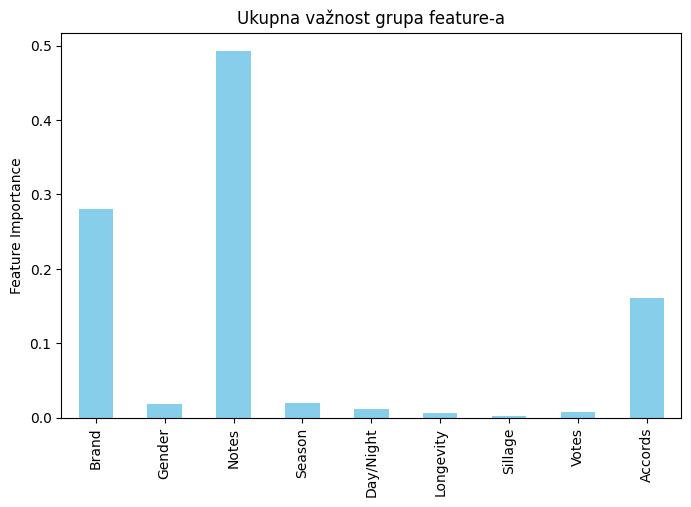

In [21]:
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
gender_importance = importances[importances.index.str.startswith("Gender_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
season_importance = importances[importances.index.str.startswith("Season_")].sum()
day_night_importance = importances[importances.index.str.startswith("Day") | importances.index.str.startswith("Night")].sum()
longevity_importance = importances["Longevity"]
sillage_importance = importances["Sillage"]
votes_importance = importances["Votes"]
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Gender:", gender_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Season:", season_importance)
print("Ukupna važnost Day/Night:", day_night_importance)
print("Važnost Longevity:", longevity_importance)
print("Važnost Sillage:", sillage_importance)
print("Važnost Votes:", votes_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Gender": gender_importance,
    "Notes": notes_importance,
    "Season": season_importance,
    "Day/Night": day_night_importance,
    "Longevity": longevity_importance,
    "Sillage": sillage_importance,
    "Votes": votes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

In [12]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)

print("XGBoost R^2:", xgb_model.score(X_test, y_test))
print("XGBoost MAE:", mean_absolute_error(y_test, y_xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_xgb_pred)))

XGBoost R^2: 0.28081412679495943
XGBoost MAE: 0.1627535074995952
XGBoost RMSE: 0.2122163387687283


Analiza _feature importance_ u okviru _XGBoost_ modela pokazuje značajnu razliku u odnosu na _Random Forest_ pristup. Kod _XGBoost_-a, jedine karakteristike koje se izdvajaju kao relevantne za predikciju ocene parfema su mirisne note (_Notes_), brend (_Brand_) i akordi (_Accords_). Ostale osobine, poput sezonske pripadnosti, dugotrajnosti, intenziteta mirisnog traga, broja glasova ili polne kategorije, nisu se pokazale kao značajne za ovaj model.

Ovakav rezultat ukazuje da _XGBoost_ algoritam najefikasnije koristi informacije o osnovnim mirisnim komponentama i poreklu parfema, dok dodatni deskriptivni podaci ne doprinose značajno tačnosti predikcije. Time se potvrđuje da je za _XGBoost_ model ključan fokus na mirisnom profilu i brendu, dok se ostale karakteristike ne mogu smatrati relevantnim u procesu učenja.

Ukupna važnost Brand: 0.28035188
Ukupna važnost Gender: 0.017851654
Ukupna važnost Notes: 0.4929208
Ukupna važnost Season: 0.019870238
Ukupna važnost Day/Night: 0.011339778
Važnost Longevity: 0.006240642
Važnost Sillage: 0.0024734067
Važnost Votes: 0.0076258723
Brand        0.280352
Gender       0.017852
Notes        0.492921
Season       0.019870
Day/Night    0.011340
Longevity    0.006241
Sillage      0.002473
Votes        0.007626
Accords      0.161326
dtype: float32


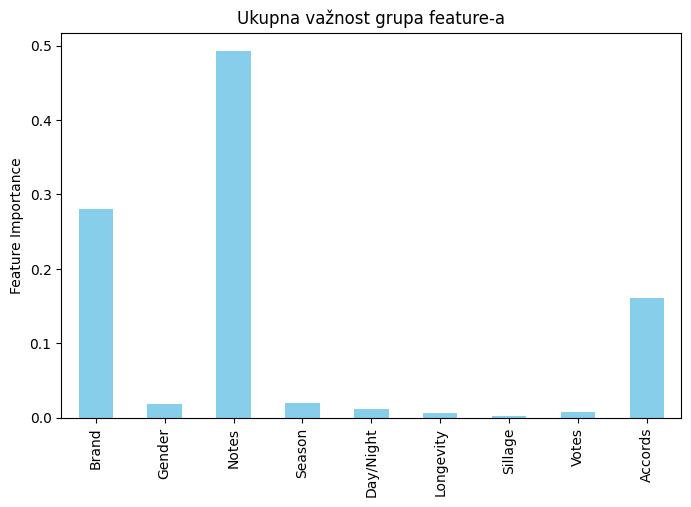

In [13]:
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
gender_importance = importances[importances.index.str.startswith("Gender_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
season_importance = importances[importances.index.str.startswith("Season_")].sum()
day_night_importance = importances[importances.index.str.startswith("Day") | importances.index.str.startswith("Night")].sum()
longevity_importance = importances["Longevity"]
sillage_importance = importances["Sillage"]
votes_importance = importances["Votes"]
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Gender:", gender_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Season:", season_importance)
print("Ukupna važnost Day/Night:", day_night_importance)
print("Važnost Longevity:", longevity_importance)
print("Važnost Sillage:", sillage_importance)
print("Važnost Votes:", votes_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Gender": gender_importance,
    "Notes": notes_importance,
    "Season": season_importance,
    "Day/Night": day_night_importance,
    "Longevity": longevity_importance,
    "Sillage": sillage_importance,
    "Votes": votes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

Probali smo da uklonimo karakteristike koje se nisu pokazale kao bitne, ali dobili smo _MAE_ losiji za 0.01.

In [14]:
recordsForXGB = []
for _, row in data.iterrows():
    recordsForXGB.append({
        "Brand": row["Brand"],
        "Accords": row["Accords"],
        "Rating": row["Rating"]
    })

In [15]:
structured_df_XGB = pd.DataFrame(recordsForXGB)
structured_df_XGB['All Notes'] = data['Notes'].apply(consolidate_notes)

In [16]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df_XGB[['Brand']]),
    columns=ohe.get_feature_names_out(['Brand'])
)

all_unique_notes = set(note for notes in structured_df_XGB['All Notes'] for note in notes)
note_df = pd.DataFrame(
    {f'Note_{note}': structured_df_XGB['All Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_notes}
)

all_unique_accords = set(accord for accords in structured_df_XGB['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df_XGB['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df_XGB = pd.concat([structured_df_XGB, note_df, accord_df], axis=1)

X = pd.concat([ohe_features, structured_df_XGB.drop(columns=['Brand', 'Rating', 'All Notes', 'Accords'])], axis=1)
y = structured_df_XGB['Rating']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
xgb_model_novo = XGBRegressor(random_state=42)
xgb_model_novo.fit(X_train, y_train)
y_xgb_pred = xgb_model_novo.predict(X_test)

print("XGBoost R^2:", xgb_model_novo.score(X_test, y_test))
print("XGBoost MAE:", mean_absolute_error(y_test, y_xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_xgb_pred)))

XGBoost R^2: 0.2054081880032761
XGBoost MAE: 0.17194012527366215
XGBoost RMSE: 0.22306441122524712


In [20]:
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Notes:", accords_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Notes": notes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

ValueError: Length of values (1167) does not match length of index (1155)